In [1]:
from matplotlib import pyplot
import seaborn

In [62]:
from metrics.utils import constants

data = "fashion-mnist"
metric = "manhattan"
report_dir = constants.DATA_ROOT.joinpath(data, metric)
tree_path = report_dir.joinpath("tree.arrow")
leaves_path = report_dir.joinpath("leaves.arrow")
distances_path = report_dir.joinpath("query-distances-batch-1-1.npy")

In [63]:
import polars

# Columns: ['name', 'depth', 'left', 'right', 'cardinality', 'arg_center', 'arg_radius', 'radius', 'lfd', 'polar_distance']
tree_df = polars.scan_ipc(tree_path)

In [64]:
selectors = [
    polars.col("radius").quantile(v / 100).alias(f"quantile-{v}")
    for v in range(10, 100, 10)
]

radii: polars.DataFrame = (
    tree_df
    .groupby("depth")
    .agg(selectors)
    .sort("depth")
    .collect()
)

In [65]:
print(type(radii))

<class 'polars.internals.dataframe.frame.DataFrame'>


In [66]:
radii.columns

['depth',
 'quantile-10',
 'quantile-20',
 'quantile-30',
 'quantile-40',
 'quantile-50',
 'quantile-60',
 'quantile-70',
 'quantile-80',
 'quantile-90']

In [67]:
import pandas

radii_pd: pandas.DataFrame = radii.to_pandas()
radii_pd.set_index("depth")
radii_pd.drop("depth", inplace=True, axis=1)
radii_pd.head()

,quantile-10,quantile-20,quantile-30,quantile-40,quantile-50,quantile-60,quantile-70,quantile-80,quantile-90
0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0,114942.0
1,78592.0,78592.0,78592.0,78592.0,105152.0,105152.0,105152.0,105152.0,105152.0
2,76667.0,76667.0,76783.0,76783.0,78825.0,78825.0,78825.0,84023.0,84023.0
3,67879.0,68024.0,69249.0,69612.0,70096.0,70096.0,70445.0,76291.0,76583.0
4,60700.0,63261.0,64976.0,65172.0,65682.0,65791.0,71260.0,72465.0,76179.0


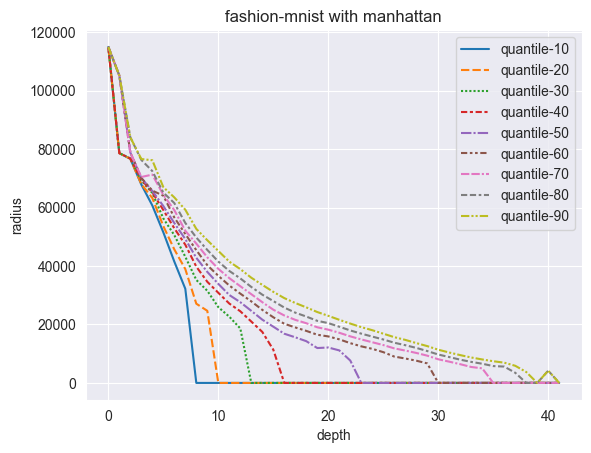

In [68]:
%matplotlib inline

ax = seaborn.lineplot(radii_pd)
ax.set_xlabel("depth")
ax.set_ylabel("radius")
ax.set_title(f"{data} with {metric}")
pyplot.savefig(constants.FIGURES_ROOT.joinpath(f"{data}-{metric}-radius-vs-depth.png"), dpi=300)

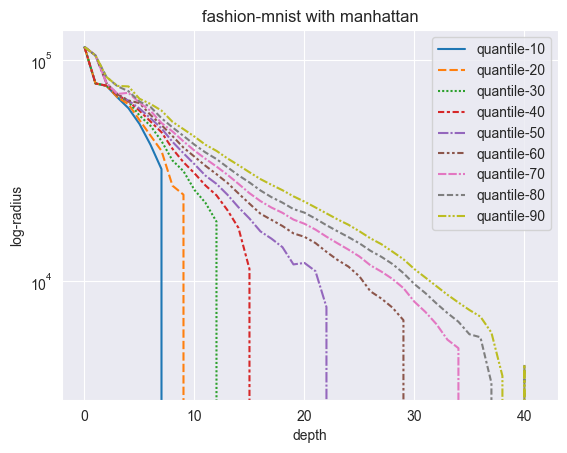

In [69]:
%matplotlib inline

ax = seaborn.lineplot(radii_pd)
ax.set_yscale("log")
ax.set_xlabel("depth")
ax.set_ylabel("log-radius")
ax.set_title(f"{data} with {metric}")
pyplot.savefig(constants.FIGURES_ROOT.joinpath(f"{data}-{metric}-log-radius-vs-depth.png"), dpi=300)